<a href="https://colab.research.google.com/github/chcmagalhaes/DS_Projetos/blob/master/DSNP_Projeto_Churn_Pediction_para_uma_empresa_de_Telecom_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
*by [Carlos Henrique](https://github.com/chcmagalhaes)*  

---


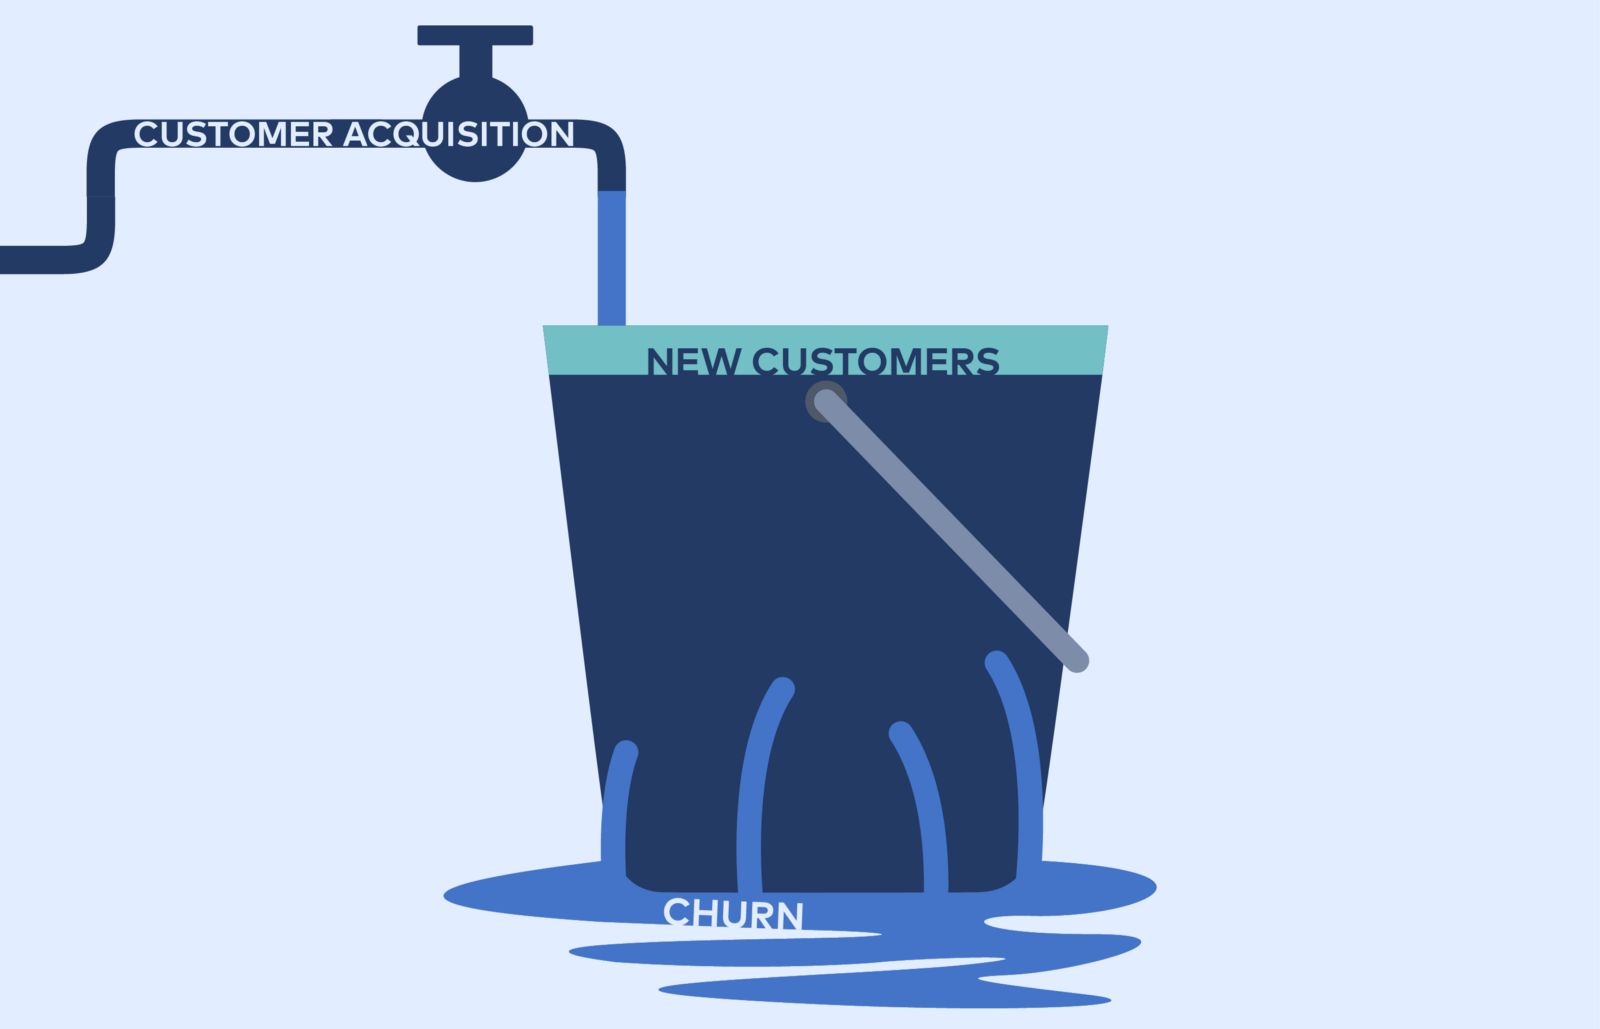

#Churn Prediction 

Hoje nos vamos falar sobre o termo *churn rate*, ou *Churn*. Que basicamente, em serviços de assinatura, detecta a taxa de cancelamento dos clientes. 


De fato o que as empresas NÃO querem é perder clientes. Então, se pudessemos criar um modelo, para avaliar e promover ações de retenção desses clientes, evitando assim um custo desnecessário do cancelamento do serviço. 



#Origem ddos dados:

Os dados serão retirados da plataforma da IBM, disponiveis nesse [*site*](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#).



In [2]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [3]:
#importar bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import FitFailedWarning
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#importar dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)



#Analise Exploratória dos dados. 

Inciamos com uma visão geral dos dados presentes no Data Frame. 

In [4]:
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print("informações do Data Frame:")
pd.DataFrame.info(df);
print("Método Describe:")
print(df.describe())
print("Verificar dados vazios:")
print(df.isnull().sum())
print("Totalizar dados das Variáveis")
print(df.nunique())


informações do Data Frame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBillin

Podemos notar, através desse método que temos 21 variáveis e 7042 entradas. 

Nosso interesse é identificar os clientes que tem risco de *churn*, logo, nossa variável alvo é a coluna Churn. 

Note que a coluna **TotalCharges**, não apareceu no método Describe, apesar de parecer um *float* ela está como *string*(object).Vamos acerta-la adiante

Há colunas também, cuja as quais não precisaremos como a customerID. Outras que precisaremos trabalhar e transforma-las em dados numéricos. 


 Ajustando os dados:  Vamos executar a função abaixo, para alterar a coluna de object para float

In [6]:
#Função para converter em float
def converter_float(entrada):
    try:
        return float(entrada)
    except ValueError:
        return np.nan



In [7]:
#converter coluna
df["TotalCharges"] = df["TotalCharges"].apply(converter_float)


Após  o método aplicado,vamos verificar se há dados ausentes, novamente.

In [8]:
 #Verificar dados vázios
 df.isnull().sum()/df.shape[0]

customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
Churn               0.000000
dtype: float64

 
Agora, identificado os dados ausentes da feture ***TotalCharges***, vamos substitui-los pela média dos demais dados desta coluna. 

Em seguida,vamos realizar uma cópia do DF, retirar a coluna **customerID** e, com a nova estrutura aplicar o *Describe*.

In [9]:
#calculando a média
TotalChargesmedia = df.TotalCharges.median()

#executar substituição:

df["TotalCharges"].fillna(TotalChargesmedia, inplace = True)

#Realizar cópia
df_new = df.copy()


#remover CostumerID
df_new = df_new.drop(["customerID"], axis = 1)

#novo Describe

df_new.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Agora, vamos verificar os *outliers*. Visualizando os dados graficamente. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

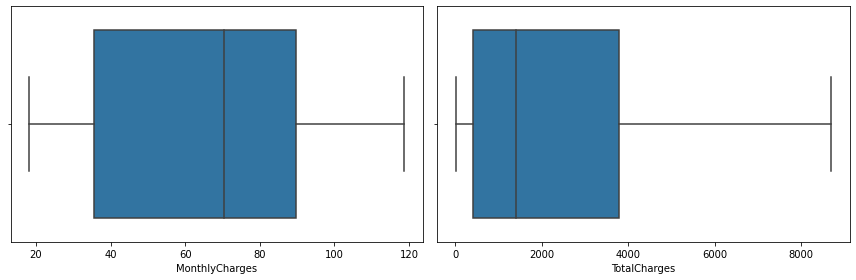

In [10]:
#plotar graficos, para verificar os outliers 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.boxplot(df_new['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_new['TotalCharges'], ax=ax[1])
plt.tight_layout();
plt.show

Nota-se que não há outliers nas duas features acima, sendo assim. Iremos agora analisar outra variável *tenure*. Que apensar de não haver nada descritivo na documentação, inferimos que seja o tempo de de assinatura do cliente em meses. Ou seja, sua fidelidade ao serviço. 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


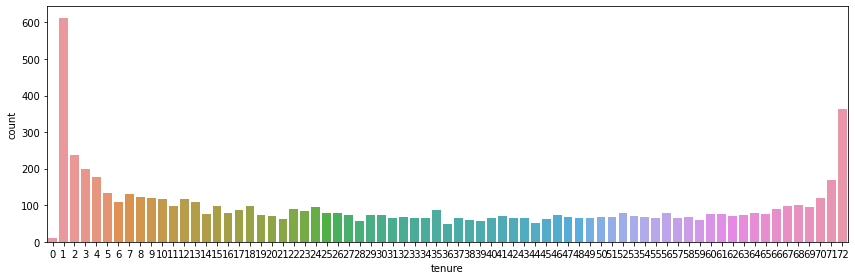

In [11]:
fig, ax = plt.subplots(figsize= (12,4))
sns.countplot(df['tenure'])
plt.tight_layout()

Agora, neste ponto precisaremos tratar as variáveis categóricas. Procurando algum viés: 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


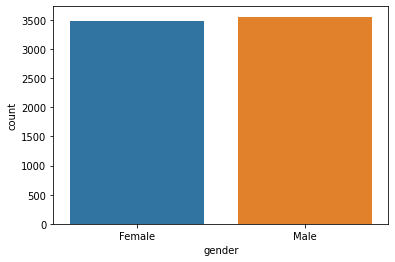

In [12]:
sns.countplot(df.gender)

Note que os gêneros estão balanceados. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


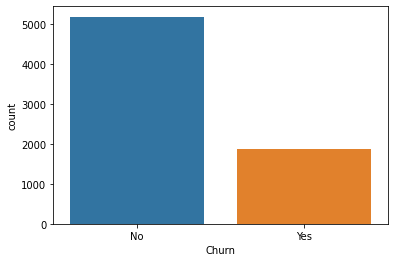

In [13]:
sns.countplot(df.Churn)

Notem acima que as o **NO** em Churn aparece muito mais do que o **Yes**. O modelo, levará isso em consideração. 


Analisamos os dois graficos acima e notamos que os dados estão balanceado, apesar da diferença em **Churn**, sabemos que é normal.  


##Preparando os dados Para o Modelo. 

Nessa etapa utilizaremos para o pré-processamento o algoritimo ***LabelEcoder***. Que substituirá as as variáveis binárias e logo após framos com as demais variáveis não binárias. 
Para isso, vamos verificar os valores unicos. 

Preparando o Pré processamento das variáveis categóricas

In [14]:
#Criar uma cópia do Data Frame
df_model = df_new.copy() 

In [15]:
#Pré-processamento
 
binary_var =df_model.nunique()[df_model.nunique()== 2].keys().tolist()
num_var = [col for col in df_model.select_dtypes(['int','float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_model.columns.tolist() if col not in binary_var + num_var]

#Processar o algoritimo labelencoder 

le = LabelEncoder()
for i in binary_var:
  df_model[i] = le.fit_transform(df_model[i])



Com o processamento acima, foi possivel realizar o ecoding das variáveis com apenas dois valores categóricos. Agora, vamos realizar outro processamento para as demais variáveis utilizando o método *Get Dummies*. 

In [16]:
#Econding para colunas multiplas de classes
df_model = pd.get_dummies(df_model, columns=cat_var)


#exibir  5entradas
df_model.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Com todas as variáveis processadas numéricamente, agora vamos realizar novamente o método **Describe**:

In [17]:
#processar DF com Describe
df_model.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,2281.916928,0.265370,0.481329,0.096834,0.421837,0.343746,0.439585,0.216669,0.496663,0.216669,0.286668,0.438450,0.216669,0.344881,0.439443,0.216669,0.343888,0.493114,0.216669,0.290217,0.398978,0.216669,0.384353,0.395428,0.216669,0.387903,0.550192,0.209144,0.240664,0.219225,0.216101,0.335794,0.228880
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,2265.270398,0.441561,0.499687,0.295752,0.493888,0.474991,0.496372,0.412004,0.500024,0.412004,0.452237,0.496232,0.412004,0.475363,0.496355,0.412004,0.475038,0.499988,0.412004,0.453895,0.489723,0.412004,0.486477,0.488977,0.412004,0.487307,0.497510,0.406726,0.427517,0.413751,0.411613,0.472301,0.420141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,402.225000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,3786.600000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


E vamos realizar também a matriz de correlação entre as variáveis.

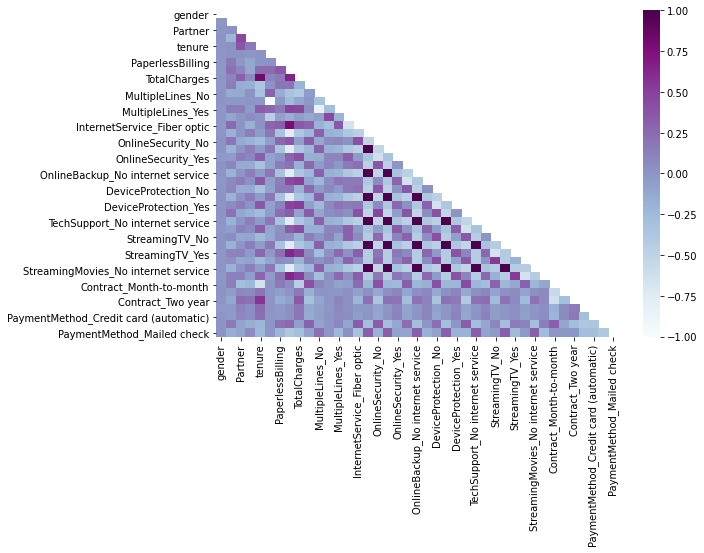

In [18]:
#Criar diagonal superior
mask = np.zeros_like(df_model.corr())
mask[np.triu_indices_from(mask)] = True

#plotar Matriz 
plt.figure(figsize= (9,6))
sns.heatmap(df_model.corr(), mask = mask, cmap= 'BuPu')
plt.show()

A Matriz de Correlação, agora com valores núméricos mostram valores fortes e positivos nessa correlação. 

#Modelo de Machine Learning

Após o processamento dos dados, feito anteriormente, vamos começar a construção do nosso modelo. Começando pela  separação dos valores da *feature matrix* da *target vector* e também da criação da base de treino e de testes.

In [19]:
#separar valores da feature matrix e da taget vactor 
X = df_model.drop("Churn", axis=1)
y = df_model["Churn"]

#dividir entre treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X,y)


###Performance

Vamos usar o *cross-validation* para estimar o erro da baseline e dos modelos.

 Depois utilizaremos a técnica *Recall* para avaliar qual é o melhor modelo. 

Vamos criar uma função de validação:



In [20]:
#função 

def valid(X, y, model, quite = False):

  X = np.array(X)
  y = np.array(y)
  pipeline = make_pipeline(StandardScaler(), model)
  scores = cross_val_score(pipeline, X, y, scoring= 'recall')

  if quite == False:
     print("Recall: {:.3f} (+/- {:.3f})".format(scores.mean(), scores.std()))

  return scores.mean()

#criando Linha base
rfc = RandomForestClassifier()
score_baseline = valid(X_treino, y_treino, rfc)

Recall: 0.480 (+/- 0.036)


Utilizamos acima o *Random Forest* sem nenhuma alteração nos parâmetros e com os dados de treino. 

Agora, com a baseline de comparação criada vamos avaliar  quais os modelos terão os melhores ou piores resultados. 

Para isso, utilizaremos a técnica *UNDER SAMPLING*. Precisaremos padronizar as escalas e realizar o balanceamento dos dados. 


In [21]:
#Padronização dos dados. 

scala = StandardScaler()
scala.fit(X_treino)

#Balanceamento:

rus = RandomUnderSampler()
X_treino_rus, y_treino_rus = rus.fit_sample(X_treino, y_treino)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


###Criando o Modelo 

Como não sabemos qual modelo irá representar o melhor resultado, vamos utilizar a validação cruzada dos seguintes modelos:
 

*   Decision Tree
*   Stochastic Gradient Descent
*   SVC
*   Regressão Logística
*   LightGBM


 


In [22]:
#instanciar modelos:
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

#criar lista de modelos
model = []
recall =[]

#avaliar desempenho - Recall

for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
  model.append(clf.__class__.__name__)
  recall.append(valid(X_treino_rus, y_treino_rus, clf, quite= True))

pd.DataFrame(data= recall, index = model, columns=['Recall'], )


,Recall
RandomForestClassifier,0.745775
DecisionTreeClassifier,0.679577
SGDClassifier,0.767606
SVC,0.771127
LogisticRegression,0.785915
XGBClassifier,0.790141
LGBMClassifier,0.747887


Com os resultados acima, *SVC, Logistic Regression e XGBosst*  tiveram os melhores resultados. 
Porém, comparando estes modelos, podemos dizer que aplicando o tunning entre os três, conseguiremos melhores resultados com o modelo *XGBoost*.


###Otimização dos hiperparâmetros

In [23]:
xgb1 = XGBClassifier (learning_rate= 0.1)

param_grid = {
    'n_estimators': range(0,1000,50),
}

#identificar melhor Parâmentro
kfold = StratifiedKFold(n_splits=10, shuffle= True)
grid_serch = GridSearchCV(xgb, param_grid, scoring ="recall", n_jobs=-1, cv=kfold)
grid_result = grid_serch.fit(X_treino_rus, y_treino_rus)

#resultados
print("Melhor:{} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor:0.7929577464788733 para {'n_estimators': 50}


In [24]:
xgb = XGBClassifier (learning_rate= 0.1,n_estimators=50)

param_grid = {
    'max_depth': range(1,8,1),
    'min_child_weight':range(1,5,1)

}

#identificar melhor Parâmentro
kfold = StratifiedKFold(n_splits=10, shuffle= True)
grid_serch = GridSearchCV(xgb, param_grid, scoring ="recall", n_jobs=-1, cv=kfold)
grid_result = grid_serch.fit(X_treino_rus, y_treino_rus)

#resultados
print("Melhor:{} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor:0.8056338028169014 para {'max_depth': 1, 'min_child_weight': 1}


In [25]:
xgb = XGBClassifier (learning_rate= 0.1,n_estimators=50, max_depth= 1, min_child_weight= 1)

param_grid = {
    'gamma':[i/10.0 for i in range(0,5)]

}

#identificar melhor Parâmentro
kfold = StratifiedKFold(n_splits=10, shuffle= True)
grid_serch = GridSearchCV(xgb, param_grid, scoring ="recall", n_jobs=-1, cv=kfold)
grid_result = grid_serch.fit(X_treino_rus, y_treino_rus)

#resultados
print("Melhor:{} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor:0.8056338028169014 para {'gamma': 0.0}


In [26]:
xgb = XGBClassifier (learning_rate= 0.1,n_estimators=50, max_depth= 1, min_child_weight= 1, gamma=0.0)

param_grid = {
    'learning_rate':[0.001, 0.01, 0.1, 1]
}

#identificar melhor Parâmentro
kfold = StratifiedKFold(n_splits=10, shuffle= True)
grid_serch = GridSearchCV(xgb, param_grid, scoring ="recall", n_jobs=-1, cv=kfold)
grid_result = grid_serch.fit(X_treino_rus, y_treino_rus)

#resultados
print("Melhor:{} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor:0.8816901408450704 para {'learning_rate': 0.001}


Após o *tuning*  e checagem de taxas de aprendizados, chegamos aos melhores valores para o modelo:
*learning_rate= 0.1,n_estimators=50, max_depth= 1, min_child_weight= 1, gamma=0.0 * 

Vamos agora executar o modelo e realizar as previsões. 

In [27]:
#modelo final 
xgb= XGBClassifier(learning_rate=0.001, n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_treino_rus,y_treino_rus)

#previsão 
X_teste = scala.transform(X_teste)
y_pred = xgb.predict(X_teste)


#Relatorio de Classificação 
print(classification_report(y_teste, y_pred))
print("Área sobre a curva AUC:", roc_auc_score(y_teste, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1312
           1       0.42      0.90      0.57       449

    accuracy                           0.65      1761
   macro avg       0.68      0.73      0.64      1761
weighted avg       0.81      0.65      0.67      1761

Área sobre a curva AUC: 0.7330738361670922


Agora, vamos plotar a Matriz de Conufusão:

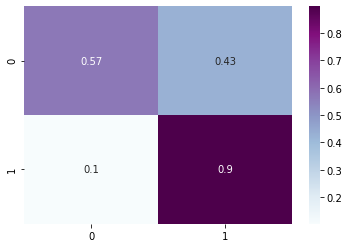

In [28]:
#Plotar Matriz de Confusão

sns.heatmap(confusion_matrix(y_teste, y_pred, normalize= 'true'), annot= True, cmap="BuPu")

##Conclusão 


Como podemos ver nosso modelo ficou muito proximo ao estimado, graças ao *tuning* dos parâmentros.
Melhoramos o aprendizado do modelo, tendo margens ainda para ainda algumas melhoras. Porém, objetivo de escolher um modelo de ML, para prever o *Churn* foi cumprido. 

